In [29]:
# Loading in data visualization, umap, and clustering packages.
library(ggplot2)
install.packages('umap')
library(umap)
install.packages('cluster')
library(cluster)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



---
### Loading in the data

In [30]:
# Reading in data_w_5_clusters
df <- read.csv("https://raw.githubusercontent.com/Cstan1987stat/health-survey-cluster-analysis/refs/heads/main/data/data_w_5_clusters.csv")

# Deleting Education, Region, and clusters columns
df$Education <- NULL
df$Region <- NULL
df$clusters <- NULL

# Creating a vector of numeric column names
num_cols <- c('Age','Weight','Height','Sleep_hours','Alcohol_drink_12m')
# Creating a vector of categorical column names
cat_cols <- c('Sex','Cancer','Coronary_heart_disease','Depression',
              'Smoked_100_cig', 'Anxiety','Aerobic.Strength')
# Printing the first 5 rows
print(head(df))

  Age    Sex Cancer Coronary_heart_disease Depression Smoked_100_cig
1  64   Male    Yes                    Yes         No            Yes
2  37 Female     No                     No         No             No
3  72 Female     No                     No         No             No
4  84 Female     No                     No         No             No
5  31 Female     No                     No         No            Yes
6  81 Female    Yes                     No         No             No
      Anxiety Height Weight Sleep_hours Aerobic.Strength Alcohol_drink_12m
1 Few times Y     74    235           8          Aerobic               108
2     Monthly     69    218           9          Aerobic                 0
3       Never     64    240           8          Neither                12
4 Few times Y     66    183           8          Neither                52
5     Monthly     69    156           8             Both                52
6 Few times Y     68    170           5          Neither           

----
### Transforming the data

In [31]:
# Loading in my standard scale and scale one hot encoder functions.
source('https://raw.githubusercontent.com/Cstan1987stat/Help-Functions/refs/heads/main/scale_one_hot_encoder.R')
source('https://raw.githubusercontent.com/Cstan1987stat/Help-Functions/refs/heads/main/standard_scale.R')

In [32]:
# Iterating through every numeric column
for (col in num_cols){
  # Sending df and col to the standard scale function
  df <- standard_scale(df, col)
}

# Iterating through every categorical column
for (col in cat_cols){
  # Sending df and col to the scale one hot encoder function
  df <- scale_one_hot_encoder(df, col)
}

---
### UMAP

In [33]:
# Setting a seed for reproducibility
set.seed(123)

# Setting up so umap will return 6 components instead of the default 2
custom.config <- umap.defaults
custom.config$n_components <- 6

# Running umap on df wiht the custom configuration
umap_df <- umap(df, config = custom.config)

In [34]:
# Creating a data frame, umap_data, using the layout from umap.
umap_data <- data.frame(umap_df$layout)
# head(umap_data)

---
### KMeans

In [35]:
# Creating initial data frame to hold the scoring metrics and number of clusters
scoring <- data.frame(clusters = numeric(), silhouette = numeric())
# Setting seed for reproducibility
set.seed(123)
# Iterating from 2 to 10 in 1 unit jumps (represents the number of clusters)
for (clust in seq(2,10,1)){
  # Running kmeans on umap data
  # - centers : number of clusters to be found
  # - nstart : how many random starts are ran
  # - iter.max : maximum number of iterations to found a solution
  km <- kmeans(umap_data, centers = clust, nstart=10, iter.max=200)
  # Isolate the found clusters
  cluster <- km$cluster
  # Calculating the silouette scores based on the found clusters and the distance matrix
  sil <- silhouette(cluster, dist(umap_data))
  # Calculating the mean silhouette score
  ss_score <- mean(sil[,3])
  # Add results to the scoring data frame
  new_row <- data.frame(clusters = clust, silhouette = ss_score)
  scoring <- rbind(scoring, new_row)
  # Outputing that clust clusters were found
  cat('Found',clust,'clusters.\n')
  flush.console()
}

Found 2 clusters.
Found 3 clusters.
Found 4 clusters.
Found 5 clusters.
Found 6 clusters.
Found 7 clusters.
Found 8 clusters.
Found 9 clusters.
Found 10 clusters.


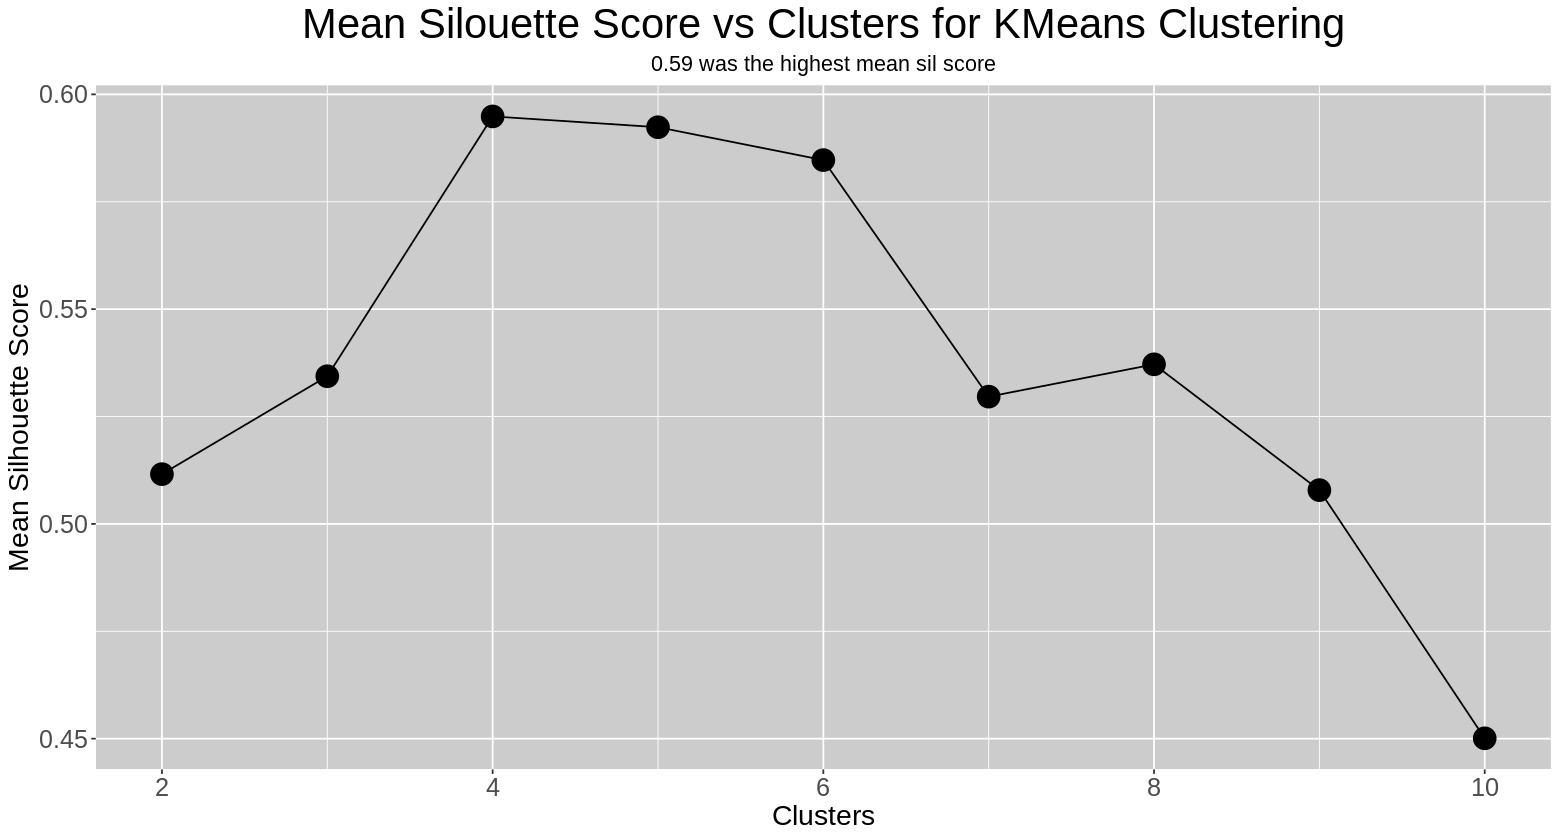

In [36]:
# Resizing plot output
options(repr.plot.width = 13, repr.plot.height = 7)
# Find the maximum mean silhouette score.
max_sil <- round(max(scoring$silhouette),2)
# Creating line plot with number of clusters on x-axis and mean silhouette score on y-axis
ggplot(data=scoring, aes(x = clusters, y = silhouette)) +
  geom_line() +
  geom_point(size=6) +
  # Customing the scale of the x-axis
  scale_x_continuous(breaks = seq(2,10,2)) +
  # Customizing x-axis and y-axis labels, along with title and subtitle
  labs(x='Clusters', y='Mean Silhouette Score', title='Mean Silouette Score vs Clusters for KMeans Clustering',
       subtitle = paste(max_sil,'was the highest mean sil score')) +
  # Adjusting text size, text alignment, and panel background color
  theme(axis.text.x = element_text(size=15.2),
        axis.text.y = element_text(size=15),
        axis.title.x = element_text(size=17),
        axis.title.y = element_text(size=17),
        plot.title = element_text(size=25, hjust = 0.5),
        panel.background = element_rect(fill = "gray80"),
        plot.subtitle = element_text(size=12.9, hjust = 0.5))

Highest mean silhouette score was 0.59 and occured with 4 clusters.

---
### Hierarchial Clustering

#### Complete Linkage

In [37]:
# Creating inital data frame to hold mean silhouette score and number of clusters
scoring <- data.frame(clusters = numeric(), silhouette = numeric())
# Setting seed
set.seed(123)
# Running hclust on the distance matrix for umap data
hc <- hclust(dist(umap_data))
# Iterating from 2 to 10 in 1 unit jumps
for (clust in seq(2,10,1)){

  # Cutting hc to get clust clusters
  clusters <- cutree(hc, k = clust)
  cluster <- clusters
  # Calculating the silhouette scores for cluster and the distance matrix
  sil <- silhouette(cluster, dist(umap_data))
  # Calculating the mean silhouette scores
  ss_score <- mean(sil[,3])
  # Add results to the scoring data frame
  new_row <- data.frame(clusters = clust, silhouette = ss_score)
  scoring <- rbind(scoring, new_row)
  # Outputing that clust clusters were found
  cat('Found',clust,'clusters.\n')
  flush.console()
}

Found 2 clusters.
Found 3 clusters.
Found 4 clusters.
Found 5 clusters.
Found 6 clusters.
Found 7 clusters.
Found 8 clusters.
Found 9 clusters.
Found 10 clusters.


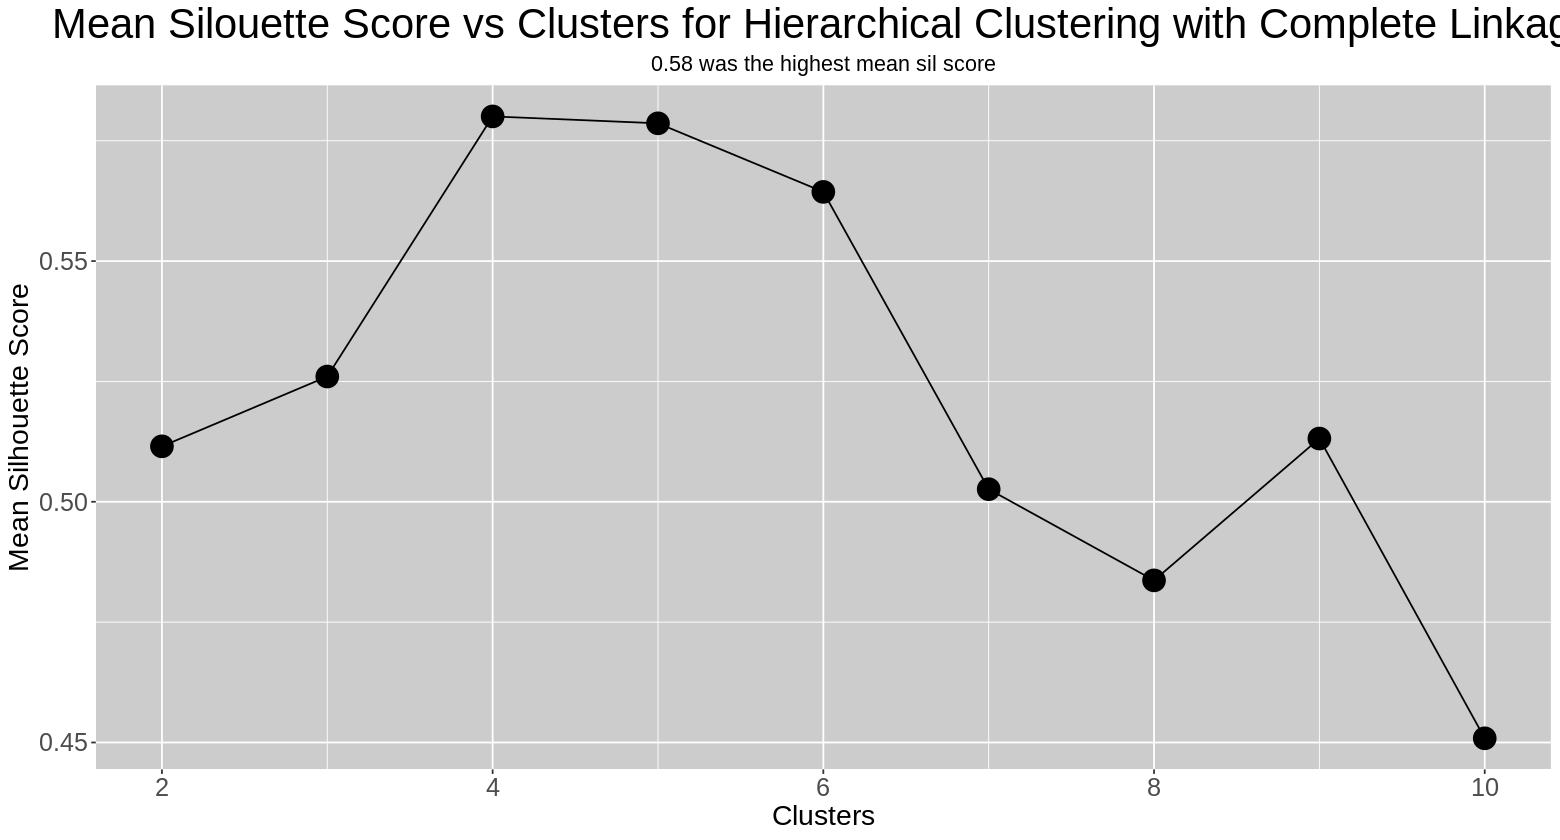

In [38]:
# Resizing plot output
options(repr.plot.width = 13, repr.plot.height = 7)
# Finding the maximum mean silhouette score
max_sil <- round(max(scoring$silhouette),2)
# Creating line plot with number of clusters on x-axis and silhouette score on y-axis
ggplot(data=scoring, aes(x = clusters, y = silhouette)) +
  geom_line() +
  geom_point(size=6) +
  # Customing the scale of the x-axis
  scale_x_continuous(breaks = seq(2,10,2)) +
  # Customizing x-axis and y-axis labels, along with title and subtitle
  labs(x='Clusters', y='Mean Silhouette Score', title='Mean Silouette Score vs Clusters for Hierarchical Clustering with Complete Linkage',
       subtitle = paste(max_sil,'was the highest mean sil score')) +
  # Adjusting text size, text alignment, and panel background color
  theme(axis.text.x = element_text(size=15.2),
        axis.text.y = element_text(size=15),
        axis.title.x = element_text(size=17),
        axis.title.y = element_text(size=17),
        plot.title = element_text(size=25, hjust = 0.5),
        panel.background = element_rect(fill = "gray80"),
        plot.subtitle = element_text(size=12.9, hjust = 0.5))

Highest mean silhouette score was 0.58 and occured wtih 4 clusters.

#### Single Linkage

In [39]:
# Creating inital data frame to hold mean silhouette score and number of clusters
scoring <- data.frame(clusters = numeric(), silhouette = numeric())
# Setting seed
set.seed(123)
# Running hclust on the distance matrix for umap data using single linkage
hc <- hclust(dist(umap_data), method = 'single')
# Iterating from 2 to 10 in 1 unit jumps
for (clust in seq(2,10,1)){

  # Cutting hc to get clust clusters
  clusters <- cutree(hc, k = clust)
  cluster <- clusters
  # Calculating the silhouette scores for cluster and the distance matrix
  sil <- silhouette(cluster, dist(umap_data))
  # Calculating the mean silhouette scores
  ss_score <- mean(sil[,3])
  # Add results to the scoring data frame
  new_row <- data.frame(clusters = clust, silhouette = ss_score)
  scoring <- rbind(scoring, new_row)
  # Outputing that clust clusters were found
  cat('Found',clust,'clusters.\n')
  flush.console()
}

Found 2 clusters.
Found 3 clusters.
Found 4 clusters.
Found 5 clusters.
Found 6 clusters.
Found 7 clusters.
Found 8 clusters.
Found 9 clusters.
Found 10 clusters.


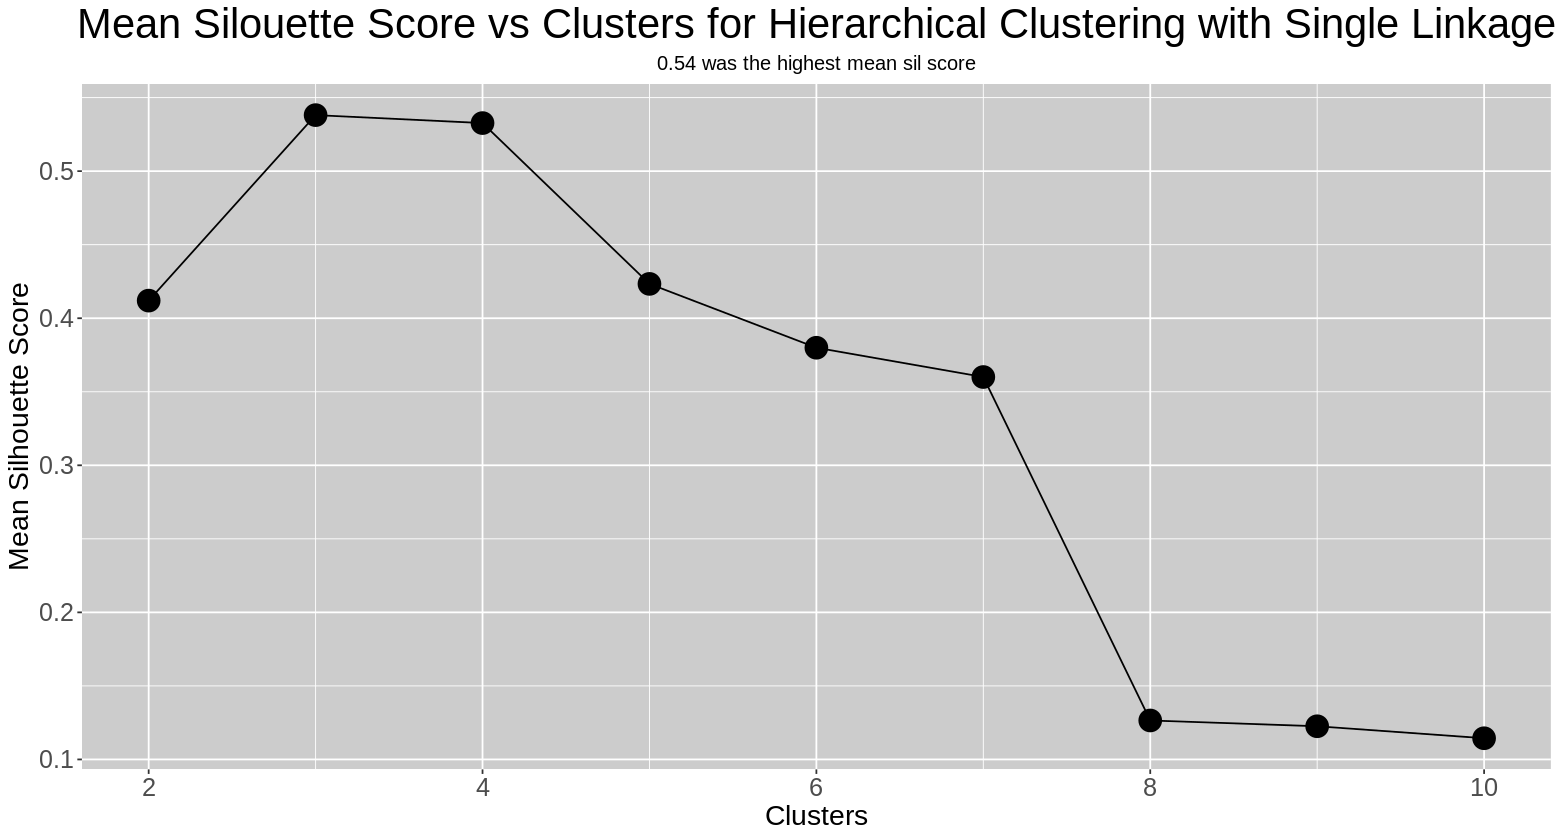

In [40]:
# Resizing plot output
options(repr.plot.width = 13, repr.plot.height = 7)
# Finding the maximum mean silhouette score
max_sil <- round(max(scoring$silhouette),2)
# Creating line plot with number of clusters on x-axis and silhouette score on y-axis
ggplot(data=scoring, aes(x = clusters, y = silhouette)) +
  geom_line() +
  geom_point(size=6) +
  # Customing the scale of the x-axis
  scale_x_continuous(breaks = seq(2,10,2)) +
  # Customizing x-axis and y-axis labels, along with title and subtitle
  labs(x='Clusters', y='Mean Silhouette Score', title='Mean Silouette Score vs Clusters for Hierarchical Clustering with Single Linkage',
       subtitle = paste(max_sil,'was the highest mean sil score')) +
  # Adjusting text size, text alignment, and panel background color
  theme(axis.text.x = element_text(size=15.2),
        axis.text.y = element_text(size=15),
        axis.title.x = element_text(size=17),
        axis.title.y = element_text(size=17),
        plot.title = element_text(size=25, hjust = 0.5),
        panel.background = element_rect(fill = "gray80"),
        plot.subtitle = element_text(size=12, hjust = 0.5))

Highest silhouette score was 0.54 and occured with 3 clusters.

#### Average Linkage

In [41]:
# Creating inital data frame to hold mean silhouette score and number of clusters
scoring <- data.frame(clusters = numeric(), silhouette = numeric())
# Setting seed
set.seed(123)
# Running hclust on the distance matrix for umap data using average linkage
hc <- hclust(dist(umap_data), method = 'average')
# Iterating from 2 to 10 in 1 unit jumps
for (clust in seq(2,10,1)){

  # Cutting hc to get clust clusters
  clusters <- cutree(hc, k = clust)
  cluster <- clusters
  # Calculating the silhouette scores for cluster and the distance matrix
  sil <- silhouette(cluster, dist(umap_data))
  # Calculating the mean silhouette scores
  ss_score <- mean(sil[,3])
  # Add results to the scoring data frame
  new_row <- data.frame(clusters = clust, silhouette = ss_score)
  scoring <- rbind(scoring, new_row)
  # Outputing that clust clusters were found
  cat('Found',clust,'clusters.\n')
  flush.console()
}

Found 2 clusters.
Found 3 clusters.
Found 4 clusters.
Found 5 clusters.
Found 6 clusters.
Found 7 clusters.
Found 8 clusters.
Found 9 clusters.
Found 10 clusters.


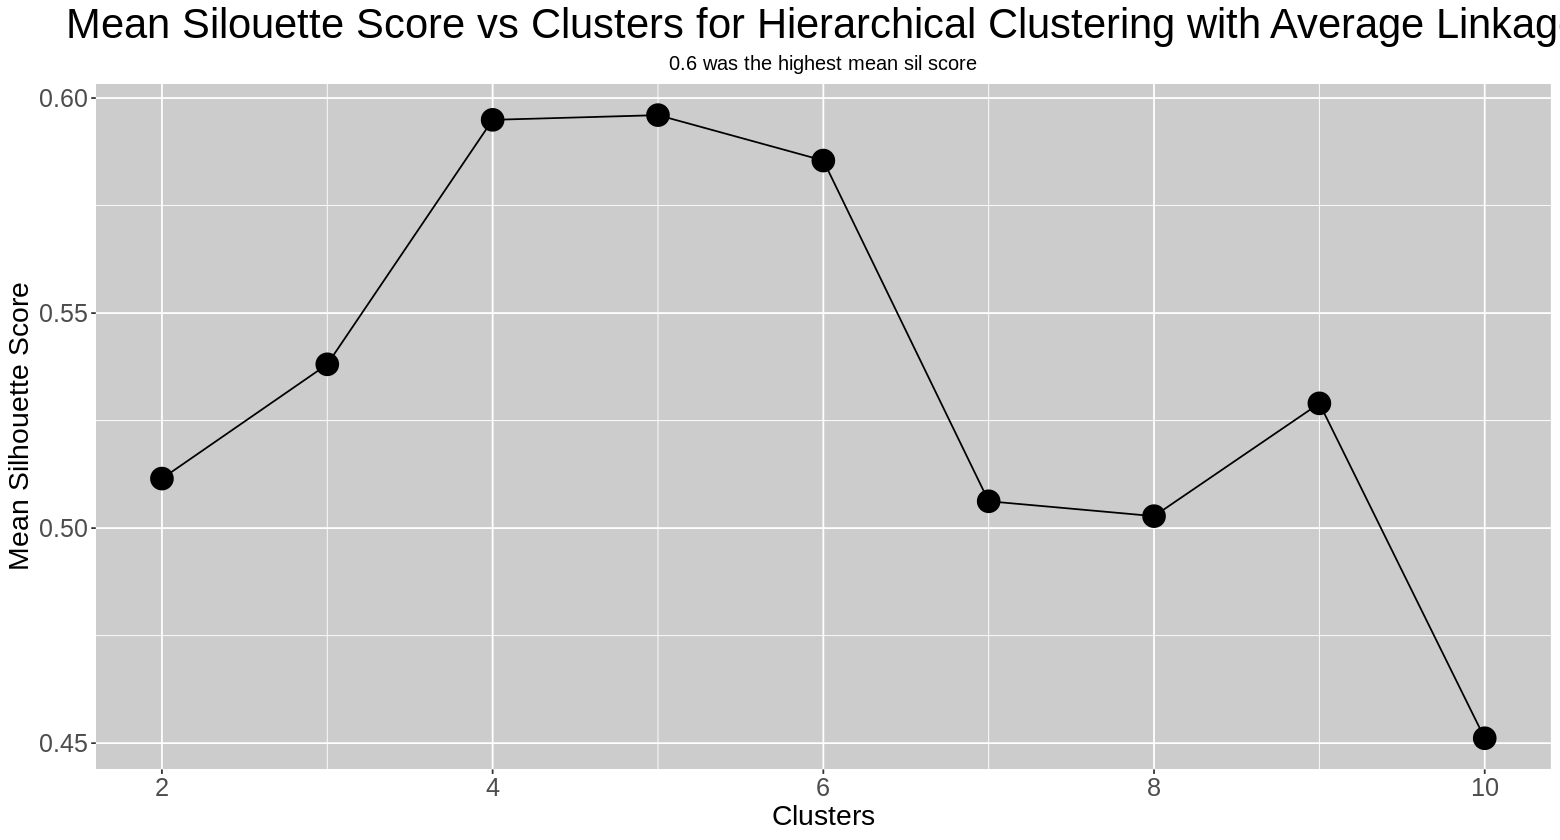

In [42]:
# Resizing plot output
options(repr.plot.width = 13, repr.plot.height = 7)
# Finding the maximum mean silhouette score
max_sil <- round(max(scoring$silhouette),2)
# Creating line plot with number of clusters on x-axis and silhouette score on y-axis
ggplot(data=scoring, aes(x = clusters, y = silhouette)) +
  geom_line() +
  geom_point(size=6) +
  # Customing the scale of the x-axis
  scale_x_continuous(breaks = seq(2,10,2)) +
  # Customizing x-axis and y-axis labels, along with title and subtitle
  labs(x='Clusters', y='Mean Silhouette Score', title='Mean Silouette Score vs Clusters for Hierarchical Clustering with Average Linkage',
       subtitle = paste(max_sil,'was the highest mean sil score')) +
  # Adjusting text size, text alignment, and panel background color
  theme(axis.text.x = element_text(size=15.2),
        axis.text.y = element_text(size=15),
        axis.title.x = element_text(size=17),
        axis.title.y = element_text(size=17),
        plot.title = element_text(size=25, hjust = 0.5),
        panel.background = element_rect(fill = "gray80"),
        plot.subtitle = element_text(size=12, hjust = 0.5))

Highest silhouette score was 0.60 and occured at 5 clusters.

---
### Exporting data with 'best' clusters

In [52]:
hc <- hclust(dist(umap_data), method = 'average')
clust <- cutree(hc, k = 5)
round(prop.table(table(clust)),2)

clust
   1    2    3    4    5 
0.25 0.26 0.11 0.25 0.13 

Cluster 2 makes up 26% of the data, clusters 1 and 4 each make up 25%, cluster 5 makes up 13%, and cluster 3 makes up 11%.

In [53]:
km <- kmeans(umap_data, centers = 4, nstart=10, iter.max=200)
round(prop.table(table(km$cluster)),2)


   1    2    3    4 
0.26 0.23 0.25 0.26 

Clusters 1 and 4 each make up 26% of the data, Cluster 3 makes up 25% of the data, and Cluster 2 makes up 23% of the data.

In [54]:
# Getting original data
df <- read.csv("https://raw.githubusercontent.com/Cstan1987stat/health-survey-cluster-analysis/refs/heads/main/data/data_w_5_clusters.csv")

# Deleting Education, Region, and clusters columns
df$Education <- NULL
df$Region <- NULL
df$clusters <- NULL

df$clusters_4_kmeans <- km$cluster
df$clusters_5_hclust <- clust

write.csv(df, 'adult_22_two_clust.csv', row.names = FALSE)